# 前処理

まずはRankings.csvとPooling.csvを読み込んで，各システムのランキングと文書の適合性を使えるようにする．あまり本質的なことはしていない．

In [1]:
import csv
import pandas as pd

CITIES = ["京都", "大阪", "渋谷", "札幌"]

def read_rankings(filepath):
    """
    各システムのランキングをクエリごとにわけてまとめる
    """
    ranking_df = pd.read_csv(filepath)
    ranking_df = ranking_df.dropna(thresh=5) # NaNが5以上ある行を削除
    system_names = ranking_df[["お名前", "システム名"]].values

    all_rankings = {}
    colname = "入力「{}」のランキング"
    for city in CITIES:
        rankings = ranking_df[colname.format(city)]
        rankings = rankings.map(lambda x: x.split("\n")).tolist()
        system_rankings = {tuple(system_name): ranking for system_name, ranking in zip(system_names, rankings)}
        all_rankings[city] = system_rankings
    return all_rankings

In [2]:
def read_pooling(filepath):
    """
    クエリごとに各文書の適合度を得る
    """
    pooling_df = pd.read_csv(filepath)
    all_qrels = {}
    for i, city in enumerate(CITIES):
        qrels = {doc_id: int(rel) for doc_id, rel in pooling_df.iloc[:,4*i:4*i+2].values if rel >= 0}
        all_qrels[city] = qrels
    return all_qrels

In [3]:
all_rankings = read_rankings("./Rankings.csv")
all_qrels = read_pooling("./Pooling.csv")

# 評価指標(Precision@5とnDCG)の計算

適合性判定結果を利用して各システムの善し悪しを数値化する．

In [4]:
from pyNTCIREVAL import Labeler
from pyNTCIREVAL.metrics import Precision, MSnDCG
from pyNTCIREVAL.metrics.metric import MetricState

GRADES = [1, 2] # nDCGの0以外の適合度
REL_LEVEL_NUM = 3 # 適合度の段階数

evaluation_values = []

for city in CITIES:
    qrels = all_qrels[city]
    labeler = Labeler(qrels)
    
    precision = Precision(cutoff=5)
    xrelnum = labeler.compute_per_level_doc_num(REL_LEVEL_NUM)
    ndcg = MSnDCG(xrelnum, GRADES, cutoff=5)
    metrics = {"P@5": precision, "nDCG@5": ndcg}
        
    for metric_name, metric in metrics.items():
        for system_name, ranked_list in all_rankings[city].items():
            labeled_ranked_list = labeler.label(ranked_list)
            result = metric.compute(labeled_ranked_list)
            evaluation_values.append((metric_name, ": ".join(system_name), city, result))

eval_df = pd.DataFrame(evaluation_values, columns=("Metric", "System", "Query", "Score"))
eval_df

,Metric,System,Query,Score
0,P@5,加藤 誠: デフォルト,京都,0.600000
1,P@5,加藤 誠: 道,京都,1.000000
2,nDCG@5,加藤 誠: デフォルト,京都,0.553146
3,nDCG@5,加藤 誠: 道,京都,0.723427
4,P@5,加藤 誠: デフォルト,大阪,1.000000
5,P@5,加藤 誠: 道,大阪,0.600000
6,nDCG@5,加藤 誠: デフォルト,大阪,0.921838
7,nDCG@5,加藤 誠: 道,大阪,0.400065
8,P@5,加藤 誠: デフォルト,渋谷,1.000000
9,P@5,加藤 誠: 道,渋谷,0.600000


# 結果の視覚化

各システムの評価指標の平均を求めてどのシステムが優れているかを視覚化する．

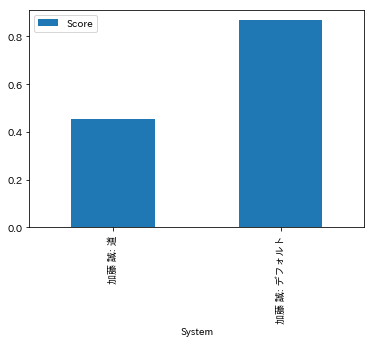

In [5]:
% matplotlib inline
import matplotlib.pyplot as plt
import japanize_matplotlib

mean_df = eval_df[eval_df.Metric == "nDCG@5"].groupby("System").mean()
mean_df.sort_values(by="Score").plot(kind="bar")